In [1]:
!nvidia-smi

Wed Mar  8 16:23:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:

# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT_PATH = '/content/drive/MyDrive/DeepLearning'

In [6]:
!pwd

/content


In [7]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/DeepLearning'

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'flowers/train'
valid_path = 'flowers/validation'


In [9]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


94765736/94765736 [==============================] - 5s 0us/step


In [10]:
# don't train existing weights
for layer in resnet50.layers:
  print(layer)

In [11]:
# don't train existing weights
for layer in resnet50.layers:
    layer.trainable = False

In [12]:
for layer in resnet50.layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [13]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
  # useful for getting number of output classes
folders = glob('flowers/train/*')

In [15]:
folders

['flowers/train/rose',
 'flowers/train/sunflower',
 'flowers/train/dandelion',
 'flowers/train/tulip',
 'flowers/train/daisy']

In [16]:
len(folders)

5

In [17]:
model = Sequential()

model.add(resnet50)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [18]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 49,279,365
Trainable params: 25,691,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [20]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
!pwd

/content/drive/MyDrive/DeepLearning


In [22]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('flowers/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1330 images belonging to 5 classes.


In [23]:
test_set = test_datagen.flow_from_directory('flowers/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 260 images belonging to 5 classes.


In [24]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
42/42 [==============================] - 467s 11s/step - loss: 3.8995 - accuracy: 0.7579 - val_loss: 3.2519 - val_accuracy: 0.2423
Epoch 2/10
42/42 [==============================] - 21s 505ms/step - loss: 0.9569 - accuracy: 0.8053 - val_loss: 2.5756 - val_accuracy: 0.3154
Epoch 3/10
42/42 [==============================] - 21s 506ms/step - loss: 1.1180 - accuracy: 0.8045 - val_loss: 3.9531 - val_accuracy: 0.2769
Epoch 4/10
42/42 [==============================] - 21s 491ms/step - loss: 0.6167 - accuracy: 0.8519 - val_loss: 2.8398 - val_accuracy: 0.2462
Epoch 5/10
42/42 [==============================] - 21s 492ms/step - loss: 0.7926 - accuracy: 0.8165 - val_loss: 4.9339 - val_accuracy: 0.3154
Epoch 6/10
42/42 [==============================] - 23s 539ms/step - loss: 0.7009 - accuracy: 0.8444 - val_loss: 3.5958 - val_accuracy: 0.3423
Epoch 7/10
42/42 [==============================] - 22s 515ms/step - loss: 0.6501 - accuracy: 0.8436 - val_loss: 3.0532 - val_accuracy: 0.2769


In [25]:
import matplotlib.pyplot as plt

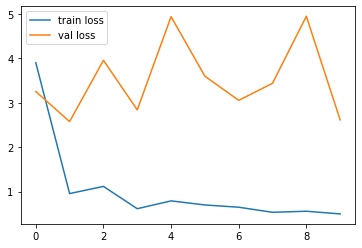

<Figure size 432x288 with 0 Axes>

In [26]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

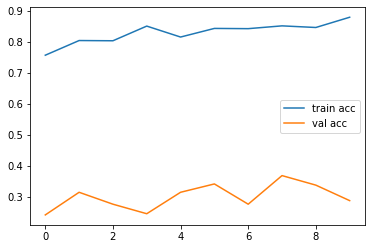

<Figure size 432x288 with 0 Axes>

In [27]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [28]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [29]:
y_pred = model.predict(test_set)

9/9 [==============================] - 3s 161ms/step


In [30]:
y_pred

array([[9.68787313e-01, 2.41069152e-04, 2.53109466e-02, 2.19415990e-03,
        3.46662523e-03],
       [7.84762502e-01, 8.52905288e-02, 4.09239158e-02, 2.89815608e-02,
        6.00414574e-02],
       [9.16119933e-01, 2.54566483e-02, 4.10540737e-02, 4.38256515e-03,
        1.29867718e-02],
       ...,
       [9.21176255e-01, 1.50168722e-03, 1.81687102e-02, 1.44873625e-02,
        4.46659438e-02],
       [9.71238256e-01, 2.88159284e-03, 1.40177505e-02, 6.43025804e-03,
        5.43224532e-03],
       [3.05723231e-02, 6.16120221e-03, 8.76569096e-03, 4.98271547e-03,
        9.49518025e-01]], dtype=float32)

In [31]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [32]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       4, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4])

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [34]:
model=load_model('model_resnet50.h5')

In [35]:
img=image.load_img('tulip.jpg',target_size=(224,224))

In [36]:
x=image.img_to_array(img)
x

array([[[17., 47., 21.],
        [17., 50., 23.],
        [14., 47., 20.],
        ...,
        [34., 60., 21.],
        [32., 58., 19.],
        [31., 57., 18.]],

       [[15., 45., 19.],
        [12., 49., 18.],
        [13., 49., 23.],
        ...,
        [34., 59., 19.],
        [30., 55., 15.],
        [33., 59., 20.]],

       [[17., 47., 21.],
        [13., 50., 19.],
        [10., 46., 20.],
        ...,
        [31., 56., 16.],
        [32., 57., 17.],
        [30., 56., 17.]],

       ...,

       [[61., 86., 56.],
        [53., 78., 49.],
        [55., 80., 51.],
        ...,
        [46., 39., 21.],
        [46., 39., 21.],
        [47., 40., 21.]],

       [[57., 82., 52.],
        [58., 78., 51.],
        [57., 77., 50.],
        ...,
        [45., 38., 20.],
        [46., 39., 21.],
        [46., 39., 20.]],

       [[59., 84., 54.],
        [57., 80., 51.],
        [56., 79., 50.],
        ...,
        [44., 37., 19.],
        [46., 39., 21.],
        [48., 41., 23.]]

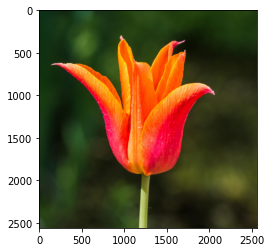

In [37]:
Z = plt.imread('tulip.jpg')
plt.imshow(Z)

In [38]:
x.shape

(224, 224, 3)

In [39]:
x=x/255

In [40]:
from keras.applications.vgg16 import preprocess_input

In [41]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [42]:
model.predict(img_data)

1/1 [==============================] - 1s 1s/step


array([[9.9978536e-01, 3.5918388e-06, 2.8299111e-05, 1.8283332e-04,
        3.7848382e-09]], dtype=float32)

In [43]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 27ms/step


In [44]:
a

array([0])

In [45]:
flower_name = ['dandelion',
 'sunflower',
 'tulip',
 'daisy',
 'rose']

In [46]:
flower_name[a[0]]

'dandelion'